In [1]:
import os
import numpy as np
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' #omit info 
from learnMSA.msa_hmm import Configuration, Align, Visualize, Emitter, Transitioner, Initializers, Training
from learnMSA.msa_hmm.SequenceDataset import SequenceDataset
from learnMSA.protein_language_models import Common, EmbeddingBatchGenerator

2024-10-29 19:51:56.393133: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-29 19:51:56.403681: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-29 19:51:56.406859: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1730231517.545270  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231517.572097  206288 cuda_executor.cc:1015] succ


# Experimental demo: learnMSA + protein language model

This notebook demonstrates how to align a set of protein sequences with learnMSA supported by a large, pre-trained protein language model.

This configuration of learnMSA - although a prototype - is the most accurate variant of learnMSA currently available. It is also the most computationally expensive. It is recommended to run this notebook on a GPU.

In [2]:
# Your fasta file with unaligned sequences.

train_filename = "test/data/egf.fasta"

# Reference file with aligned sequences that have matching IDs to (potentially a subset of) the 
# sequences in the train_file.
# Replace with empty string if no reference is available.
ref_filename = "test/data/egf.ref"

# The number of independently trained models.
num_models = 4

# Use sequence weights based on a rapid pre-clustering of the sequences (requires mmseqs2 to be installed)
use_weights = True

# Align long insertions with an external aligner left unaligned by the main MSA stage (requires famsa to be installed).
align_insertions = True

HMM training supported by protein embeddings:

In [3]:
def align(filename, out_filename):
    scoring_model_config = Common.ScoringModelConfig()
    config = Configuration.make_default(num_models, 
                                        use_language_model=True, 
                                        scoring_model_config=scoring_model_config,
                                        frozen_insertions=True,
                                        num_prior_components=10,
                                        V2_emitter=True,
                                        V2_temperature=3.)
    # we have to define a special model- and batch generator if using a language model
    # because the emission probabilities are computed differently and the LM requires specific inputs
    model_gen = EmbeddingBatchGenerator.make_generic_embedding_model_generator(config["scoring_model_config"].dim)
    batch_gen = EmbeddingBatchGenerator.EmbeddingBatchGenerator(config["scoring_model_config"])
    with SequenceDataset(train_filename, fmt="fasta") as data:
        config["crop_long_seqs"] = int(np.ceil(3 * np.mean(data.seq_lens))) #comment out to disable cropping
        alignment_model = Align.run_learnMSA(data,
                                            out_filename,
                                            config, 
                                            model_generator=model_gen,
                                            batch_generator=batch_gen,
                                            sequence_weights=Align.compute_sequence_weights(train_filename, "tmp", config["cluster_seq_id"]),
                                            verbose=True,
                                            align_insertions=True)
    return alignment_model

Training of 4 models on file egf.fasta
Configuration: 
{
num_models : 4
transitioner : ProfileHMMTransitioner(
 transition_init=
    {
    begin_to_match : DefaultEntry() , match_to_end : DefaultExit() , 
    match_to_match : DefaultMatchTransition(1) , match_to_insert : DefaultMatchTransition(-1) , 
    insert_to_match : Norm(0, 0.1) , insert_to_insert : Norm(-0.5, 0.1) , 
    match_to_delete : DefaultMatchTransition(-1) , delete_to_match : Norm(0, 0.1) , 
    delete_to_delete : Norm(-0.5, 0.1) , left_flank_loop : Norm(0, 0.1) , 
    left_flank_exit : Norm(-1, 0.1) , right_flank_loop : Norm(0, 0.1) , 
    right_flank_exit : Norm(-1, 0.1) , unannotated_segment_loop : Norm(0, 0.1) , 
    unannotated_segment_exit : Norm(-1, 0.1) , end_to_unannotated_segment : Norm(-9, 0.1) , 
    end_to_right_flank : Norm(0, 0.1) , end_to_terminal : Norm(0, 0.1)
    },
 flank_init=Const(0.0),
 prior=ProfileHMMTransitionPrior(match_comp=1, insert_comp=1, delete_comp=1, alpha_flank=7000, alpha_single=10000

/home/beckerf/mambaforge/envs/learnMSAdev2/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Computing all embeddings (this may take a while).
10% done.
20% done.
30% done.
40% done.
50% done.
60% done.
70% done.
80% done.
90% done.
100% done.
Fitting models of lengths [24 25 23 25] on 7774 sequences.
Batch size= 190 Learning rate= 0.05
Using sequence weights  [1.         0.33333334 0.07692308 ... 0.04347826 0.02777778 0.25      ] .
Using 1 GPUs.


I0000 00:00:1730231583.412203  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231583.412475  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231583.412685  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231583.412927  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/10


I0000 00:00:1730231585.410698  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231585.410935  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231585.411108  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231585.411311  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

46/46 - 18s - 389ms/step - loss: 112.2706 - loglik: -9.4683e+01 - prior: -1.7382e+01 - aux_loss: 0.2054
Epoch 2/10
46/46 - 4s - 79ms/step - loss: 76.6445 - loglik: -7.1810e+01 - prior: -4.2977e+00 - aux_loss: 0.5364
Epoch 3/10
46/46 - 4s - 80ms/step - loss: 73.4697 - loglik: -7.0076e+01 - prior: -2.8463e+00 - aux_loss: 0.5471
Epoch 4/10
46/46 - 4s - 80ms/step - loss: 72.8903 - loglik: -6.9993e+01 - prior: -2.3508e+00 - aux_loss: 0.5464
Epoch 5/10
46/46 - 4s - 82ms/step - loss: 72.4636 - loglik: -6.9763e+01 - prior: -2.1545e+00 - aux_loss: 0.5463
Epoch 6/10
46/46 - 3s - 68ms/step - loss: 72.3439 - loglik: -6.9726e+01 - prior: -2.0688e+00 - aux_loss: 0.5488
Epoch 7/10
46/46 - 3s - 66ms/step - loss: 72.2074 - loglik: -6.9646e+01 - prior: -2.0136e+00 - aux_loss: 0.5482
Epoch 8/10
46/46 - 3s - 69ms/step - loss: 72.2319 - loglik: -6.9706e+01 - prior: -1.9781e+00 - aux_loss: 0.5481


I0000 00:00:1730231629.296618  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231629.296894  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231629.297105  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231629.297350  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

expansions model 0: [(12, 5), (13, 2), (14, 1), (15, 1)]
discards model 0: []
expansions model 1: [(12, 2), (13, 3), (14, 1), (15, 1), (16, 1)]
discards model 1: []
expansions model 2: [(12, 9)]
discards model 2: []
expansions model 3: [(12, 2), (13, 3), (14, 1), (15, 1), (16, 1)]
discards model 3: []
Re-initialized the encoder parameters.
Fitting models of lengths [33, 33, 32, 33] on 7774 sequences.
Batch size= 190 Learning rate= 0.05
Using sequence weights  [1.         0.33333334 0.07692308 ... 0.04347826 0.02777778 0.25      ] .
Using 1 GPUs.


I0000 00:00:1730231634.012394  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231634.012657  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231634.012836  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231634.013051  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/4


I0000 00:00:1730231635.712494  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231635.712741  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231635.712919  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231635.713128  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

46/46 - 16s - 358ms/step - loss: 82.1068 - loglik: -6.4511e+01 - prior: -1.7117e+01 - aux_loss: 0.4789
Epoch 2/4
46/46 - 3s - 73ms/step - loss: 67.3989 - loglik: -6.2672e+01 - prior: -4.1843e+00 - aux_loss: 0.5427
Epoch 3/4
46/46 - 3s - 72ms/step - loss: 66.0343 - loglik: -6.3097e+01 - prior: -2.3957e+00 - aux_loss: 0.5421
Epoch 4/4
46/46 - 2s - 54ms/step - loss: 65.5124 - loglik: -6.3174e+01 - prior: -1.7941e+00 - aux_loss: 0.5443


I0000 00:00:1730231662.981208  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231662.981458  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231662.981639  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231662.981850  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

expansions model 0: []
discards model 0: [16 18]
expansions model 1: []
discards model 1: [12 15]
expansions model 2: []
discards model 2: [16]
expansions model 3: []
discards model 3: [12 15]
Re-initialized the encoder parameters.
Fitting models of lengths [31, 31, 31, 31] on 7774 sequences.
Batch size= 190 Learning rate= 0.05
Using sequence weights  [1.         0.33333334 0.07692308 ... 0.04347826 0.02777778 0.25      ] .
Using 1 GPUs.


I0000 00:00:1730231668.779008  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231668.779257  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231668.779434  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231668.779653  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/4


I0000 00:00:1730231670.491838  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231670.492116  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231670.492328  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231670.492574  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

46/46 - 16s - 359ms/step - loss: 78.3714 - loglik: -6.1960e+01 - prior: -1.5854e+01 - aux_loss: 0.5578
Epoch 2/4
46/46 - 3s - 63ms/step - loss: 67.0051 - loglik: -6.2742e+01 - prior: -3.7048e+00 - aux_loss: 0.5580
Epoch 3/4
46/46 - 3s - 62ms/step - loss: 65.6150 - loglik: -6.3010e+01 - prior: -2.0448e+00 - aux_loss: 0.5599
Epoch 4/4
46/46 - 3s - 65ms/step - loss: 65.1838 - loglik: -6.3139e+01 - prior: -1.4850e+00 - aux_loss: 0.5601


I0000 00:00:1730231696.887415  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231696.887678  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231696.887862  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231696.888076  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

expansions model 0: []
discards model 0: []
expansions model 1: [(0, 1)]
discards model 1: []
expansions model 2: []
discards model 2: []
expansions model 3: []
discards model 3: []
Re-initialized the encoder parameters.
Fitting models of lengths [31, 32, 31, 31] on 7774 sequences.
Batch size= 190 Learning rate= 0.05
Using sequence weights  [1.         0.33333334 0.07692308 ... 0.04347826 0.02777778 0.25      ] .
Using 1 GPUs.


I0000 00:00:1730231701.725418  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231701.725667  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231701.725848  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231701.726060  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Epoch 1/20


I0000 00:00:1730231703.631554  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231703.631803  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231703.631984  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231703.632196  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

46/46 - 16s - 358ms/step - loss: 83.4291 - loglik: -6.1916e+01 - prior: -2.0970e+01 - aux_loss: 0.5426
Epoch 2/20
46/46 - 3s - 74ms/step - loss: 67.7425 - loglik: -6.2835e+01 - prior: -4.3636e+00 - aux_loss: 0.5440
Epoch 3/20
46/46 - 3s - 73ms/step - loss: 65.8623 - loglik: -6.3099e+01 - prior: -2.2162e+00 - aux_loss: 0.5467
Epoch 4/20
46/46 - 3s - 75ms/step - loss: 65.2506 - loglik: -6.3208e+01 - prior: -1.4974e+00 - aux_loss: 0.5448
Epoch 5/20
46/46 - 3s - 75ms/step - loss: 65.0193 - loglik: -6.3262e+01 - prior: -1.2113e+00 - aux_loss: 0.5457
Epoch 6/20
46/46 - 3s - 75ms/step - loss: 64.8610 - loglik: -6.3256e+01 - prior: -1.0642e+00 - aux_loss: 0.5411
Epoch 7/20
46/46 - 3s - 72ms/step - loss: 64.7144 - loglik: -6.3187e+01 - prior: -9.8469e-01 - aux_loss: 0.5426
Epoch 8/20
46/46 - 3s - 71ms/step - loss: 64.6610 - loglik: -6.3191e+01 - prior: -9.2633e-01 - aux_loss: 0.5436
Epoch 9/20
46/46 - 4s - 80ms/step - loss: 64.5319 - loglik: -6.3107e+01 - prior: -8.8230e-01 - aux_loss: 0.5429
E

I0000 00:00:1730231754.767238  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231754.767481  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231754.767676  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231754.767891  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Aligning 2 insertion slices with famsa.


/home/beckerf/mambaforge/envs/learnMSAdev2/lib/python3.12/site-packages/Bio/SeqRecord.py:228: BiopythonDeprecationWarning: Using a string as the sequence is deprecated and will raise a TypeError in future. It has been converted to a Seq object.
  warnings.warn(


time for generating output: 3.0915
Wrote file test/data/interactive.alignment.fasta
41/41 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step
>l=-52.26_t=0.01
.....................$CD.......P............NP......CYN.HG..TCS......................L.......RAT..GYTCSC..L....PR......YT....GEH$..........................
>l=-56.76_t=0.01
.....................$CD.......S............QP......CRN.-G..TCSl.....................N.......TNT..DYTCAC..F....PG......YT....GRY$..........................
>l=-47.80_t=0.01
.....................$CD.......S............DP......CLN.GG..TCT......................Lr......SLD..SYSCAC..A....PG......YT....GQH$..........................
>l=-61.04_t=0.01
.....................$CD.......H............VT......CLN.GG..TCQ......................Lk......TLE..DYTCAC..A....NG......YT....GER$..........................
>l=-61.88_t=0.01
.....................$CD.......H............VT......CLN.GG..TCQ......................Lk......TLE..EYTCAC..A....NG......YT....GDR$..........................
>l=-61.54_t

/home/beckerf/mambaforge/envs/learnMSAdev2/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['sequences', 'indices', 'embeddings']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(
I0000 00:00:1730231762.197464  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231762.197677  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730231762.197855  206288 cuda_executor.cc:1015] successful NUMA node read from SysFS had negati

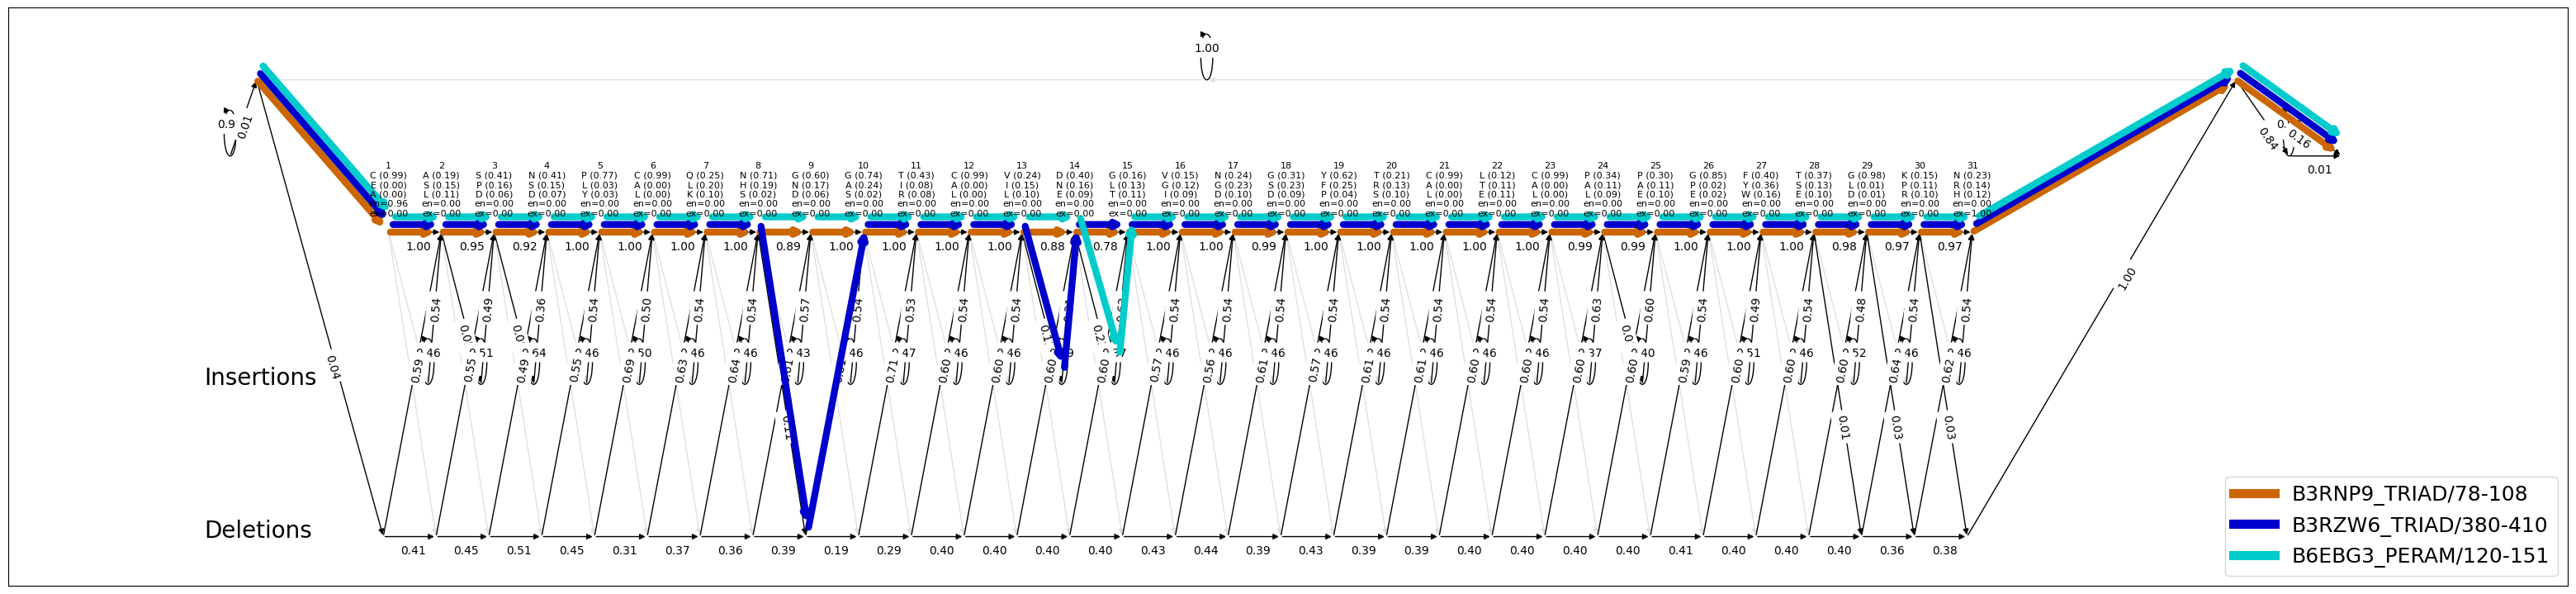

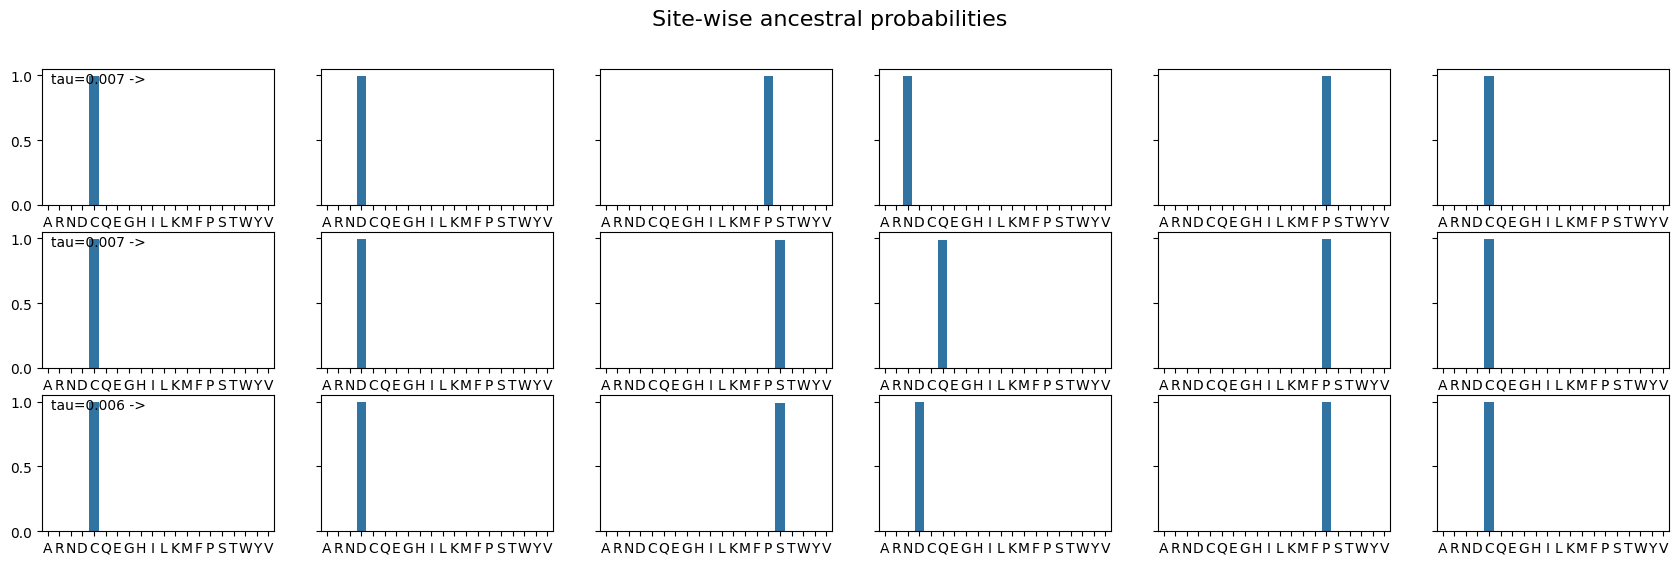

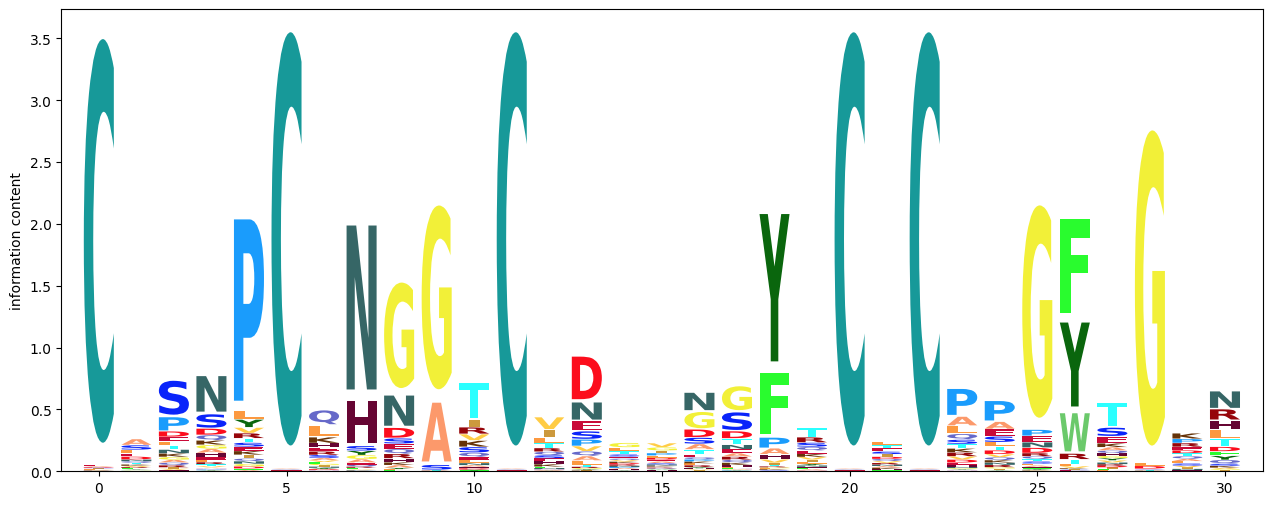

In [4]:
alignment_model = align(train_filename, "test/data/interactive.alignment.fasta") 
Visualize.print_and_plot(alignment_model, alignment_model.best_model)

In [5]:
!id_list=$(sed -n '/^>/p' {ref_filename} | sed 's/^.//') ; export MAX_N_PID_4_TCOFFEE=10000000 ; t_coffee -other_pg seq_reformat -in test/data/interactive.alignment.fasta -action +extract_seq_list ${{id_list[@]}} +rm_gap > test/data/interactive.projection.fasta

HERE: 1ixa
HERE: 1apo
HERE: 1urk
HERE: 1fsb
HERE: 1esl
HERE: 1hre
HERE: 1epi
HERE: 4tgf
HERE: 1hcgb
HERE: 1dan1
HERE: 1dan2
HERE: 1rfnb


In [6]:
!t_coffee -other_pg aln_compare -al1 {ref_filename} -al2 test/data/interactive.projection.fasta -compare_mode sp

*****************************************************
seq1       seq2          Sim   [ALL]           Tot  
egf           12         31.1    72.8 [100.0]   [ 5182]
